# PytzMLS2018: Lab 3: Deep learning for computer vision

<center>**Anthony Faustine (sambaiga@gmail.com)**</center>


## Import all necessary libries and modules we will use

In [1]:
import sys
sys.path.append('../src')
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import time
import copy
from ploting import *
import PIL
%matplotlib inline

In [2]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## Part 1. Convolutional Neural Network

**Learning goal**: How to implement a CNN using PyTorch. In this lab we will train a CNN using PyTorch. 


**Task**: Build CNN image classifier to recognize fashion image using the  FashionMNIST dataset.  FashionMNIST contains contains Zalando’s article images with 60,000 images in the training set and 10,000 in the test set. Each sample is a 28×28 grayscale image with a label from 10 classes: t-shirt, trouser, pullver, dress, coat, sandal, shirt, sneaker, bag and ankle boot.

 This dataset base designed to be used as a drop-in replacement of the original MNST dataset.

** Procedure**

1. Load the training and test datasets using DataLoader
2. Define a Feedforwad Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


### 1.1 Load dataset

We will use DataLoader and TensorDataset (from torch.utils.data) for convinience in data handling. You can create your custom dataset class by inheriting Dataset with some required member functions.

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors and normalise the image. 

In [3]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root='../data/fashionmnist', train=True, download=True, transform=transform)
                          

test_dataset = torchvision.datasets.FashionMNIST(root='../data/fashionmnist', train=False, download=True, transform=transform)

Processing...
Done!


In [5]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

### 1.1.1 Make iteratable data loader

In [6]:
batch_size = 4


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### 1.1.2  Visualize train dataset


Let's inspect a few examples. 

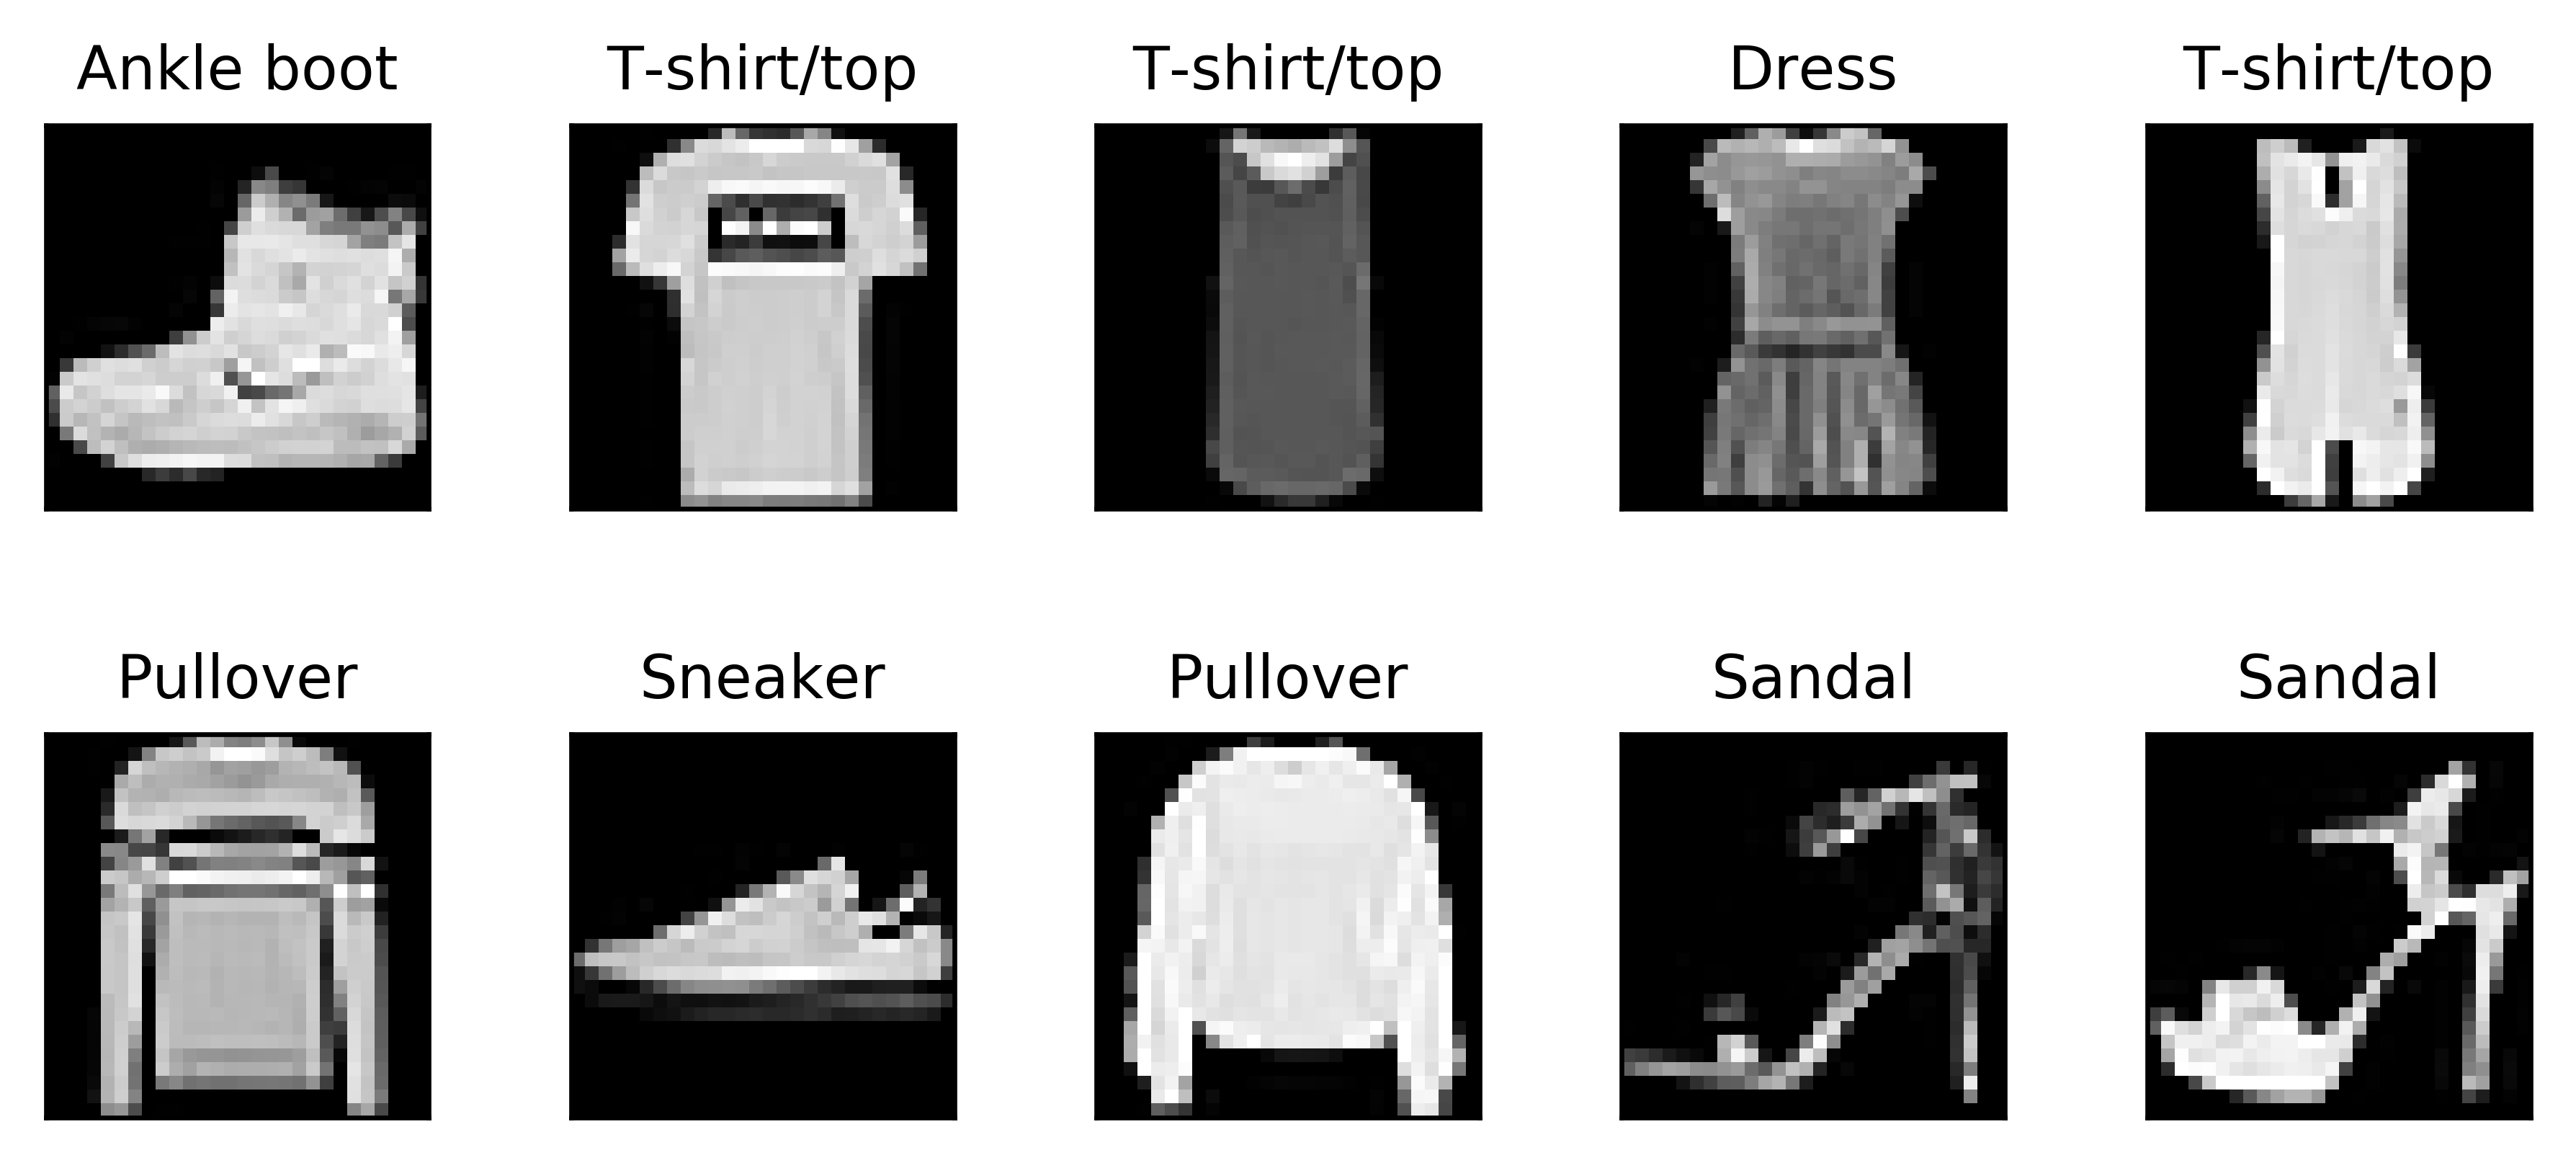

In [9]:
beatify(fig_width=6)
fig, axs = plt.subplots(2,5, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.25, wspace=.1)
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(train_dataset.train_data[i].numpy(), cmap='gray', interpolation='none')
    axs[i].set_title('%s' % classes[train_dataset.train_labels[i]], fontsize=10)
    plt.tight_layout()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
  

### 1.2. Define  CNN model

In this step we define CNN model in which a key module for constructing a convolutional net is nn.ConvXd. Although we use 2-dimensional convolution layer, parameters are almost same for all X-dimensional convolution layers. You need to specify the number of input channels (in_channels), the number of output channels (out_channels), the kernel (filter) size (kernel_size), stride size (stride), zero-padding (padding), and so forth as discussed in the tutorial.

We will use 2 convolution layers with max pooling and they are followed by 2 fully-connected layers with RELU activation. We do not apply any activation at the output layer to use activation-combined loss function for a better numerical stability. The network is shown below:

`conv(1)=>ReLU=>MaxPool=>Conv2=>ReLU=>MaxPool=>FC1=>FC2`



**Conv1**:
- in_channel (D) = 1 (since the image is Grey scale)
- out_chabbel (K) = 10
- Filter_size (F) = 5
- Stride_size (S) = 1

self.conv1 = nn.Conv2d(1, 10, 5)

**MaxPool**:
- Filter size (F)=2
- Stride (S)=2

self.pool = nn.MaxPool2d(2, 2)

**Conv2**:
- in_channel (D) = 10 (output_channel of Conv1)
- out_chabbel (K) = 20
- Filter_size (F) = 5
- Stride_size (S) = 1
- self.conv2 = nn.Conv2d(10, 20, 5)


**Questions**
1. What is the purpose of pooling layer?
2. What is the output size of conv1 and conv2?
3. What is the output size of MaxPool layer 1 and MaxPool layer 2?
4. Show that the input dimension of FC1 is $4\times 4\times 20$

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20*4*4, 10)
       


    def forward(self, x):
        out  = F.relu(self.conv1(x))
        out  = self.pool(out)
        out  = F.relu(self.conv2(out))
        out = self.pool(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        return out

In [ ]:
model = CNN()
print(model)

### 1.3. Define a Loss function and Optimizer¶

Since this is multi-class classification we will use **Cross Entropy loss**. PyTorch provide **Cross Entropy loss**  loss function which combines a softmax layer and the **Cross Entropy loss** together and it is more numerically stable than using them separately. Thus it is why we didnt  apply softmax activation after the output layer while defining MLP model. See the last model definition above.

We will use SGD with momentum as our optimizer. When we create an optimizer in PyTorch, we need to pass parameters that we want to optimize (train) as input arguments. We can retrieve all trainable parameters of the model by calling **model.parameters()**.

**Questions**
1. Write an expression of a softmax function.
2. What are the advantage of using SGD with momentum in training neural network?

In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 1.4. Train the network
Now, we need to train the model. For each full coverage of train dataset, we just need to do a forward pass computation with a mini-batch of dataset and a backward pass to compute gradients followed by a step of optimization. We need to do this for a reasonable number of iterations.

In [ ]:
def train(model, optimizer, num_epochs):
    
    
    total_loss = []
    print("Start training")
    
    for epoch in range(num_epochs):
        
        training_loss = []
        
        model.train()
        
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)
        
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
        
            # Forward pass to get output/logits
            outputs = model(images)
        
            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)
            
        
            # Getting gradients w.r.t. parameters
            loss.backward()
        
            # Updating parameters
            optimizer.step()
            training_loss.append(loss.data[0])
        
            # print statistics
            # print statistics
           
            if i %4000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch+1, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), np.mean(training_loss)))
             
              
        total_loss.append(np.mean(training_loss))     
        
       
    return total_loss    
          

In [ ]:
total_loss = train(model, optimizer, 5)

### 1.4.1 Visualize training loss

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(total_loss, label="rate={}".format(learning_rate))
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

### 1.5 Test the network on the test data

In [ ]:
def test(model):
    
    model.eval()
    
    correct = 0
    predictions=[]
    ground_t=[]
    
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images)
        labels = Variable(labels)

        outputs = model(images)
        
        # Get predictions from the maximum value
        _, pred = torch.max(outputs.data, 1)
        predictions  += pred.numpy().tolist()
        ground_t+= labels.data.numpy().tolist()
        #correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        correct += torch.sum(pred == labels.data)
    
    print('')
    predictions = np.array(predictions)
    ground_t    = np.array(ground_t)   
    accuracy = 100. * correct / len(test_loader.dataset)
        
    print("Accuracy: {}%".format(accuracy))
    
    return ground_t, predictions
    

In [ ]:
ground_t, predictions = test(model)

### 1.5.1 VIsualize Results

In [ ]:
correct_indices = np.nonzero(predictions == ground_t)[0]
incorrect_indices = np.nonzero(predictions != ground_t)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

#### 1.5.1.1 Visualize correct prediction

In [ ]:
#plt.figure(figsize=(10,6))
indices = np.random.permutation(correct_indices)
figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_dataset.test_data[correct].numpy(),  cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual {}".format(classes[predictions[correct]], classes[ground_t[correct]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### 1.5.1.2 Visualize incorrect prediction

In [ ]:
indices = np.random.permutation(incorrect_indices)
figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_dataset.test_data[correct].numpy(), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual {}".format(classes[predictions[correct]], classes[ground_t[correct]]))
    plt.xticks([])
    plt.tight_layout()
    plt.yticks([])

## Task:
1. What techniques can you use to improve the predictive accuracy?
2. Modify the network or the training procedure to improve the performance.
3. What is the maximum possible accuracy did you achive from step number 2?

## Part 2 Transfer learning

**Transfer learning**  is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

**Why Transfer Learning?**
- In practice, very few people train an entire CNN from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

- Very Deep Networks are expensive to train. The most complex models take weeks to train using hundreds of machines equipped with expensive GPUs.For example, training ResNet18 for 30 epochs in 4 NVIDIA K80 GPU took us 3 days. Training ResNet152 for 120 epochs in the same GPUs takes 4 months.
- Determining the topology/flavour/training method/hyper parameters for deep learning is a black art with not much theory to guide you.

"DON'T TRY TO BE AN HERO" ~Andrej Karapathy


### Transfer learning Strategies:

In general, there are two strategies to perform transfer learning,

 **Fine-tuning**: consists of using the pretrained network on the base dataset and train all layers in the target dataset. The startegy is useful when the new dataset is large and very different from the original dataset. Since you have large dataset, you can design your own network or use the existing ones. Train the network using random initialisations or use the pre-trained network weights as initialisers. The second one is generally preferred.
 
If the new dataset is small but very different from the original dataset you will need  to extract the features from the earlier layer and train a classifier on top of that. To achieve this you will need to add a few FC layers and output layer, set the weights for earlier layers and freeze them and then train the network. 


**Feature Extractor** 
 
 - **Freeze all layer except the final one**: which consists of leaving all but the last layer frozen (the weights are not updated) and train the last layer. Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained. This strategy is useful if the new dataset is small and similar to original dataset.
 
Pytorch Implementation

```python
for params in model_.parameters():
    params.requires_grad = False 
```    

- **Freezing the first few layers**: In this case you will need to freeze the first few layers and train the network.This strategy is useful if the new dataset is larger and similar to original dataset. 

Pytorch implementation freezing the first 5 layers 

```python
ct = 0
for name, child in model.named_children():
    ct += 1
    if ct < 5:
        for name2, params in child.named_parameters():
        params.requires_grad = False         
```            

### 2. 1 Transfer learning 1: Build a classifier for detecting ants and bees

**Learning goal**: How to implement a Transfer learning using PyTorch.



**Task**: Build CNN image classifier to classifiy ants and bees. The dataset have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

** Procedure**

1. Download dataset and perform data augementation.
2. Load and define models for transfer learning

#### 2.1.1 Download dataset and perform data augementation

Download the dataset from this [link](https://download.pytorch.org/tutorial/hymenoptera_data.zip). For this lab the data can be found in `../data/hymenoptera/` directory.

In [10]:
PATH = "../data/hymenoptera/"

The data directory should contain train and valid directories. The train and val directory have subdirs for each class you wish to recognize (in this case, 'beens' and 'ants'). we can verify if these directory are present in the defined PATH.

In [11]:
import os
os.listdir(PATH)

['val', 'train']

To view sub-directory in valid folder

In [12]:
os.listdir(f'{PATH}val')

['ants', 'bees']

We can also view some files in this directory

In [13]:
files = os.listdir(f'{PATH}val/bees')[:5]
files

['936182217_c4caa5222d.jpg',
 '348291597_ee836fbb1a.jpg',
 '272986700_d4d4bf8c4b.jpg',
 '2506114833_90a41c5267.jpg',
 '2709775832_85b4b50a57.jpg']

In [14]:
from PIL import Image
image = Image.open(f'{PATH}val/bees/{files[0]}')
image.show()

### Task: 
- Visualize few images for ants in train directory
- What is the size, mode and format of these image?

#### Data Augementation
Data augmentation is a process where you make changes to existing images like adjusting the colors , flipping it horizontally or vertically , scaling , cropping and many more. Pytorch provides a very useful library called `torchvision.transforms` which provides a lot of methods which helps to apply data augmentation. transforms comes with a `compose` method which takes a list of transformation. The pre-trained models expect input  mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

First we create a `transform` object that transform for train and test images:

- For train images resize  image to 224 size by croping to random size and aspect ratioin order to ensure that the training runs quickly, horizontally flip the given image randomly with a given probability (default p=0.5) and transform to tesnsor and finalize normalize the image.

- For valid images we resize  image to 256, crops at the center to 224, transform to tensor and finalize normalize the image.

In [15]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [16]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),transform[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


### Visualize a few images after transformation

Let’s visualize a few training images so as to understand the data augmentations.

In [17]:
def inverse_transform(inp):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp
    

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inverse_transform(inp)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')

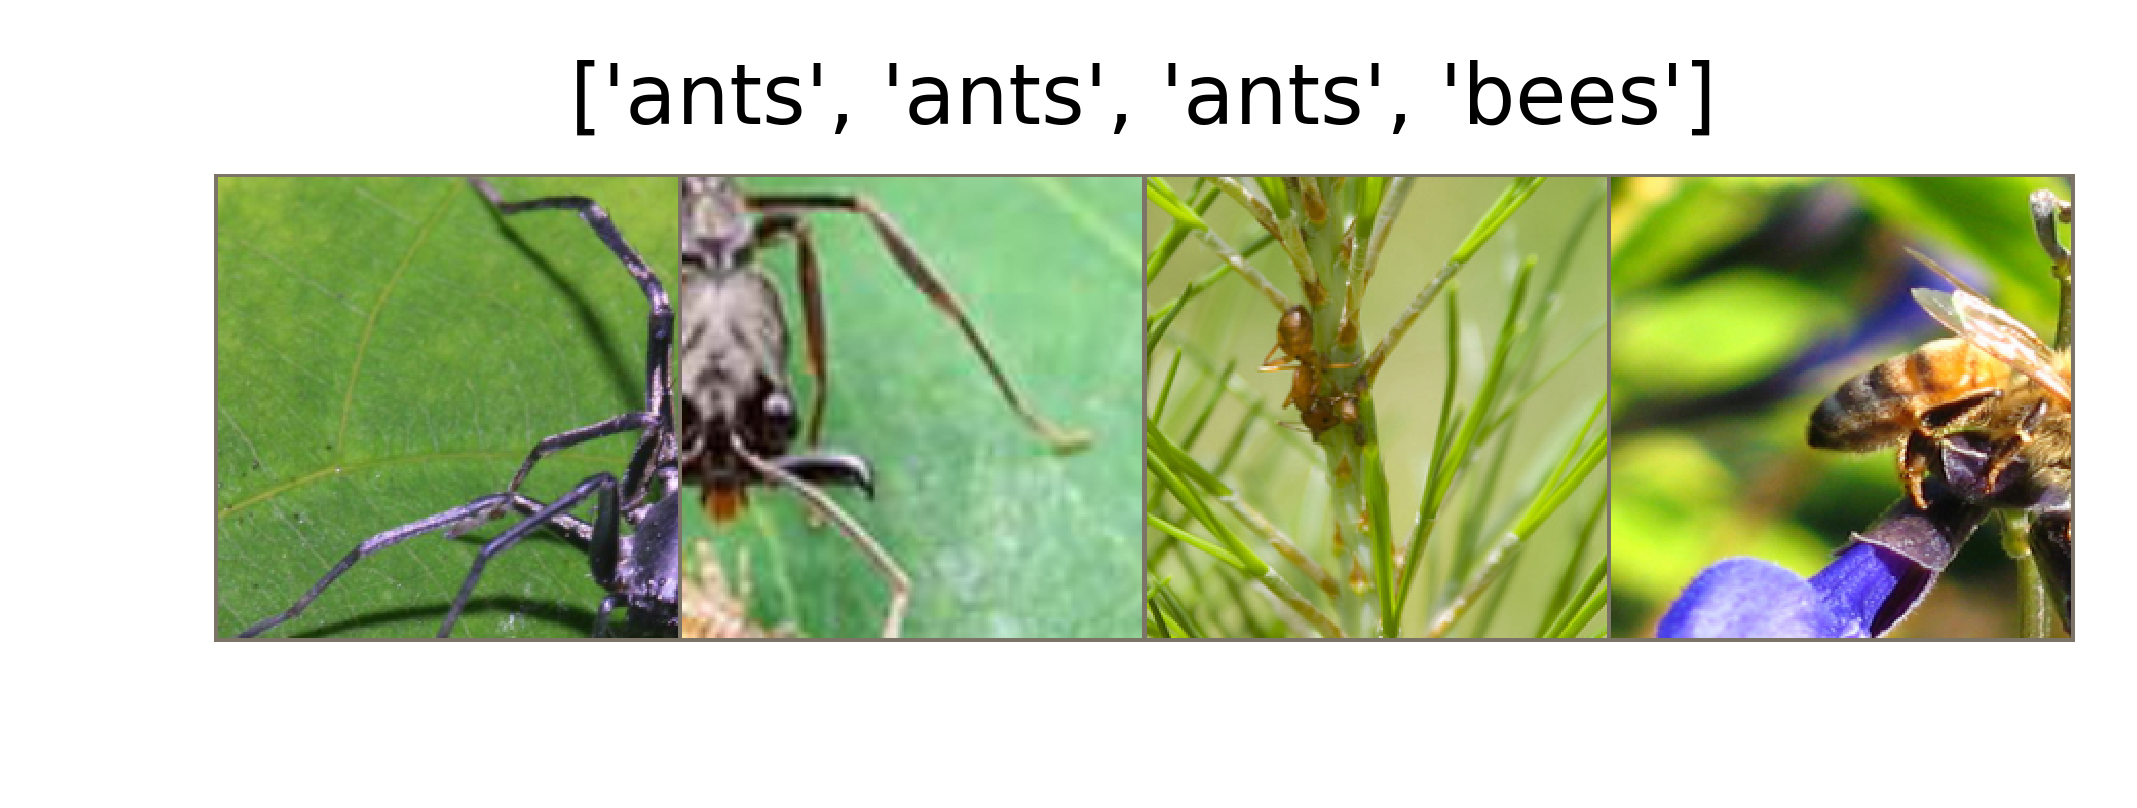

In [19]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

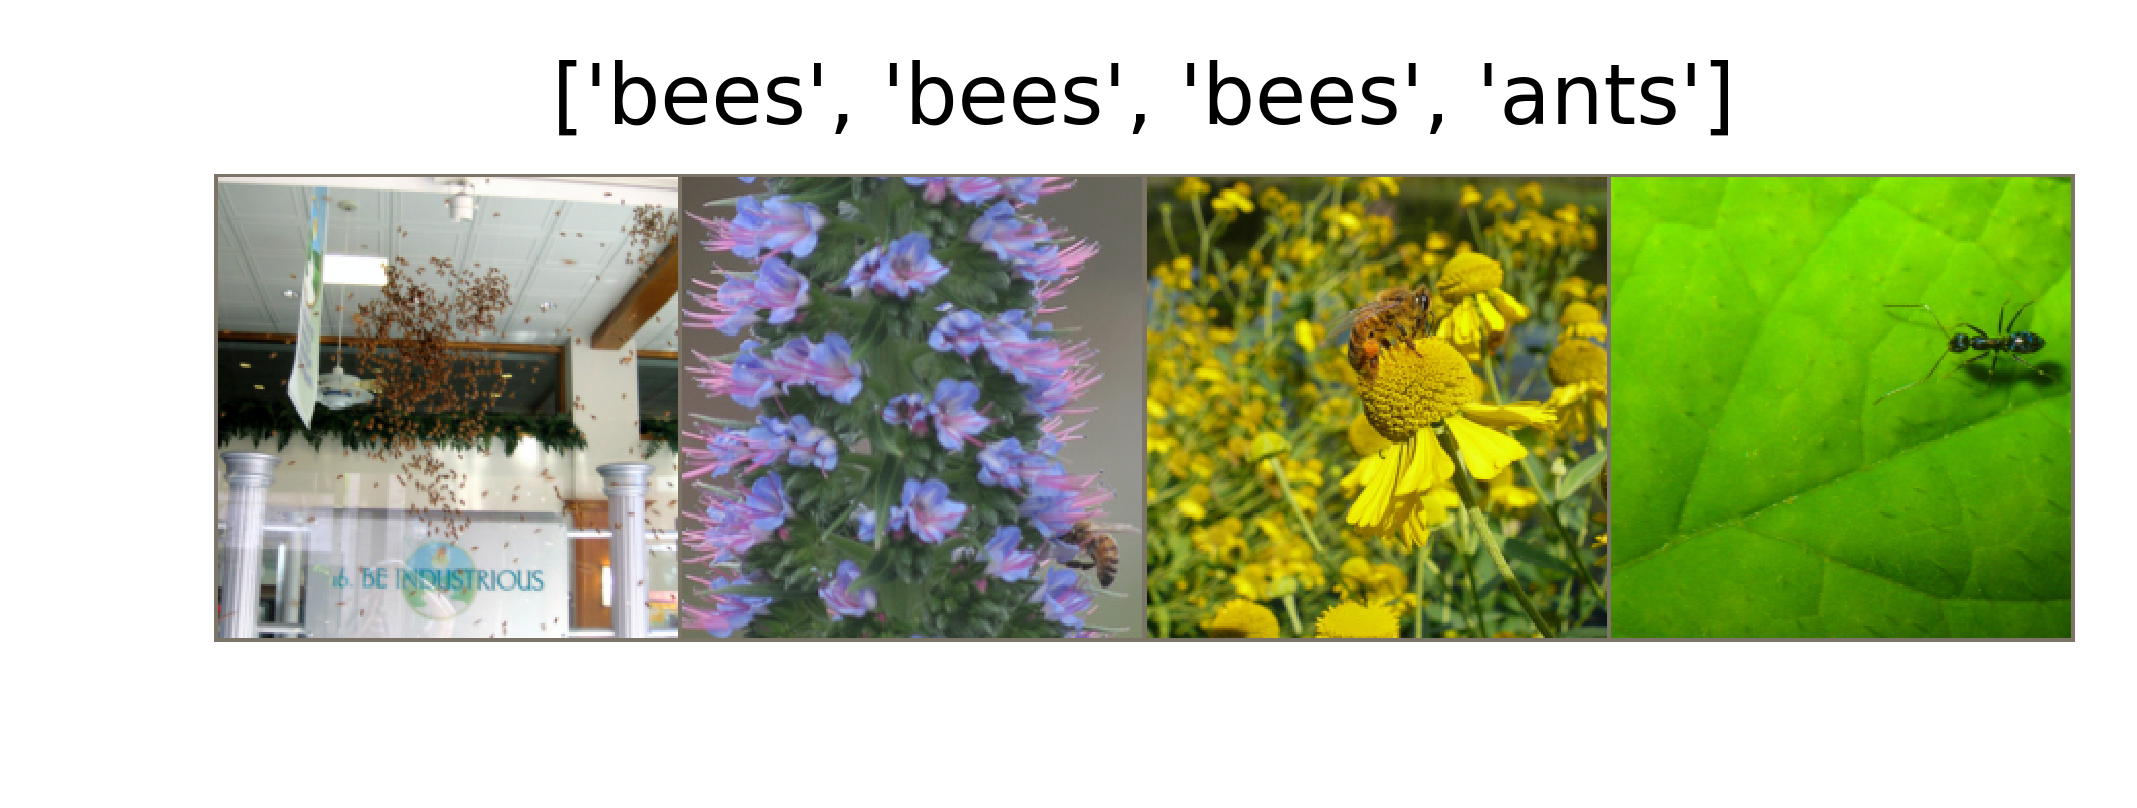

In [20]:
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

### 2.1.2 Load and define models for transfer learning: Finetuning the convnet



We will use a model called [**ResNet**](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035) from Microsoft which won the ImageNet competition in 2015. The ResNet model compromises of a bunch of ResNet blocks(Combination of convolution and identity block) and a fully connected layer. The model is trained on Imagenet dataset on 1000 categories , we will remove the last fully connected layer and add a new fully connected layer which outputs 2 categories which tells the probability of the image being Ant or Bee. For this problem we will use finetuning strategies.

#### Load a pretrained model and reset final fully connected layer.

In [21]:
model_resnet18 = models.resnet18(pretrained=True)
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

We use Resnet18 here. If you have more computational power, feel free to swap it with Resnet50, Resnet100 or Resnet152. Since we are doing fine-tuning, or transfer learning we will use the pretrained net weights. 

In [22]:
# get number of feature from the final FC layer
num_features = model_resnet18.fc.in_features

Since imagenet as 1000 classes , We need to change our last layer according to the number of classes we have

In [23]:
#define FC layer with two output category
model_resnet18.fc = nn.Linear(num_features, 2)

In [24]:
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

### 2.1.2.1 Define loss function and Optimizer

In [25]:
criterion = nn.CrossEntropyLoss()   

In [26]:
optimizer_rst18 = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)

### Decaying  Learning rate
Most of the times we start with a higher learning rate so that we can reduce the loss faster and then after a few epochs you would like to reduce it so that the learning becoming slower. `torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs. The `StepLR` function sets the learning rate of each parameter group to the initial lr decayed by gamma every step_size epochs. When last_epoch=-1, sets initial lr as lr.

In [27]:
from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 2 epochs
scheduler_lr = lr_scheduler.StepLR(optimizer_rst18 , step_size=5)

Check if cuda availabe and change the model and criterion to cuda()

In [28]:
if torch.cuda.is_available():
    model_resnet18 = model_resnet18.cuda()
    criterion = criterion.cuda()

### 2.1.2.2 Training the model
Now, let's write a general function to train a model. Here, we will illustrate. The function will Schedule the learning rate and save the best model.

In [29]:
def fit_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [30]:
model_best = fit_model(model_resnet18, criterion, optimizer_rst18,  scheduler_lr, dataloaders, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.4681 Acc: 0.7623
val Loss: 0.2341 Acc: 0.9150

Epoch 2/10
----------
train Loss: 0.5646 Acc: 0.7459
val Loss: 0.4582 Acc: 0.8170

Epoch 3/10
----------
train Loss: 0.5777 Acc: 0.7582
val Loss: 0.7133 Acc: 0.7386

Epoch 4/10
----------
train Loss: 0.6930 Acc: 0.7500
val Loss: 0.6328 Acc: 0.7974

Epoch 5/10
----------
train Loss: 0.6782 Acc: 0.7705
val Loss: 0.4232 Acc: 0.8824

Epoch 6/10
----------
train Loss: 0.3823 Acc: 0.8361
val Loss: 0.3288 Acc: 0.9085

Epoch 7/10
----------
train Loss: 0.4045 Acc: 0.8525
val Loss: 0.2999 Acc: 0.9150

Epoch 8/10
----------
train Loss: 0.3723 Acc: 0.8607
val Loss: 0.3316 Acc: 0.9150

Epoch 9/10
----------
train Loss: 0.3597 Acc: 0.8566
val Loss: 0.3315 Acc: 0.9085

Epoch 10/10
----------
train Loss: 0.4140 Acc: 0.8320
val Loss: 0.3098 Acc: 0.9150

Training complete in 10m 35s
Best val Acc: 0.915033


### 2.1.2.3 Visualize prediction

Let us write a generic function to display predictions for a some images

In [31]:
def visualize_model(model, num_images=6):
    
    training_mode = model.training
    model.eval()
    images_so_far = 0
    

    for i, data in enumerate(dataloaders['val']):
        
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, int(num_images/2), images_so_far)
            plt.imshow(inverse_transform(inputs.cpu().data[j]))
            plt.title('predicted: {}'.format(class_names[preds[j]]), fontsize=8)
            plt.tight_layout()
            plt.xticks([])
            plt.yticks([])
            #ax.axis('off')
    
            if images_so_far == num_images:
                model.train(mode=training_mode)
                return
    model.train(mode=training_mode)

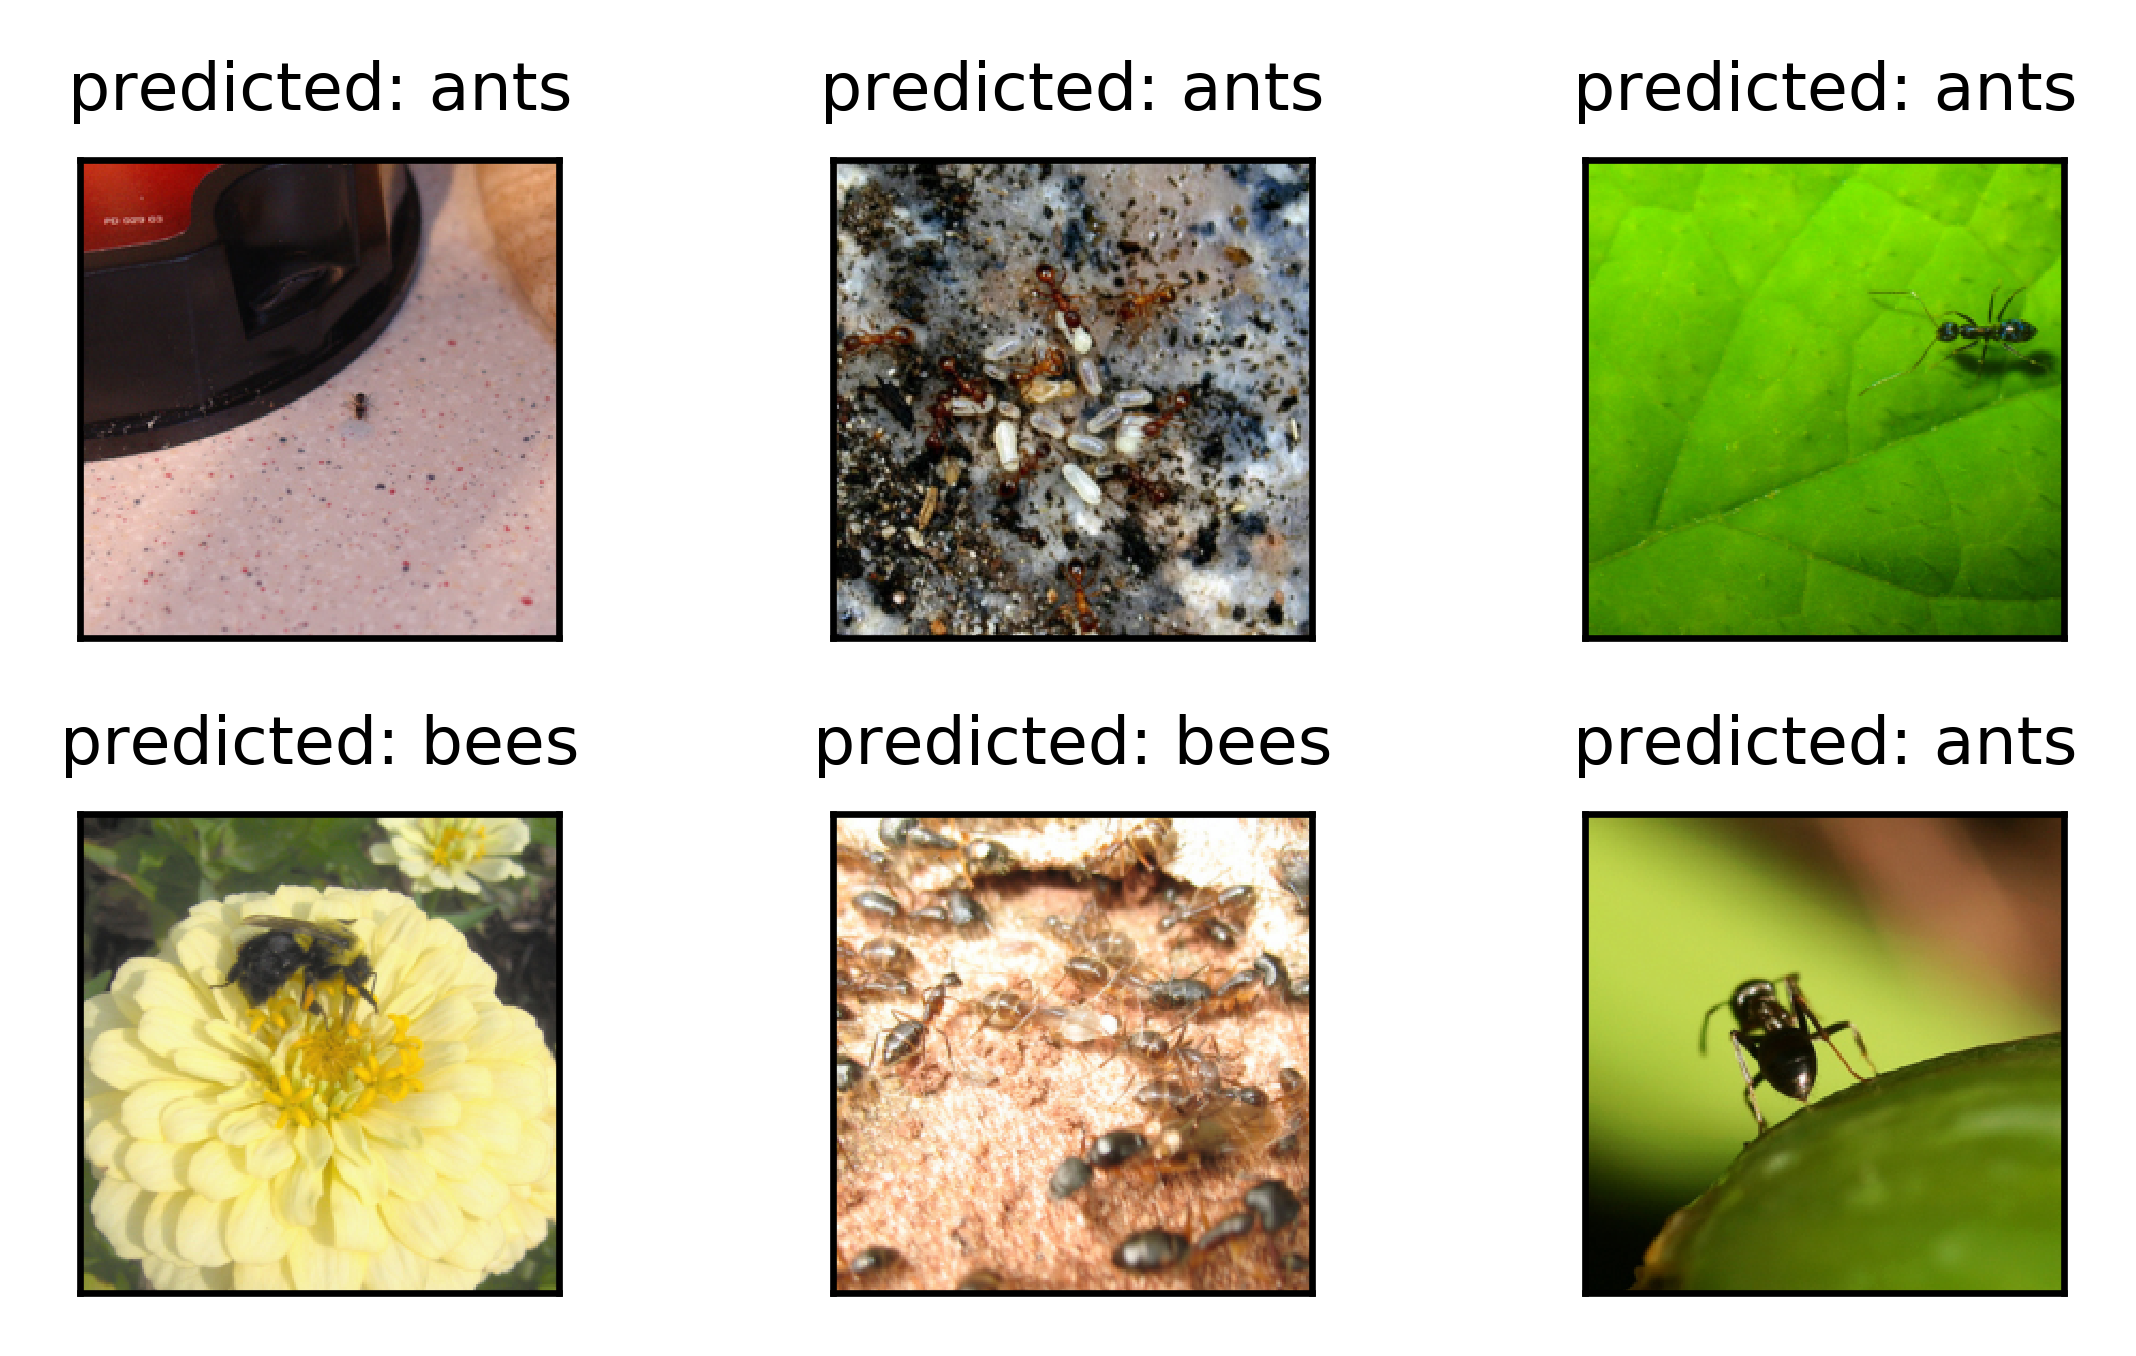

In [32]:
beatify(fig_width=4)
visualize_model(model_best)

### 2.1.3 Load and define models for transfer learning: ConvNet as fixed feature extractor


Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>__.

In [33]:
model_resnet18_conv = models.resnet18(pretrained=True)
for param in model_resnet18_conv.parameters():
    param.requires_grad = False

Parameters of newly constructed modules have requires_grad=True by default

In [34]:
num_feature = model_resnet18_conv.fc.in_features
model_resnet18_conv.fc = nn.Linear(num_feature, 2)

### 2.1.3.1 Define loss function and Optimizer

In [35]:
criterion = nn.CrossEntropyLoss()   

In [36]:
optimizer_rst18_conv = torch.optim.SGD(model_resnet18_conv.fc.parameters(), lr=0.001, momentum=0.9)

### NOTE:
Observe that only parameters of final layer are being optimized as opoosed to before.

In [37]:
#Define schedule
scheduler_lr_conv = lr_scheduler.StepLR(optimizer_rst18_conv, step_size=5)

In [38]:
#Check if Cuda is available
if torch.cuda.is_available():
    model_resnet18_conv = model_resnet18_conv.cuda()
    criterion = criterion.cuda()

### 2.1.3.1 Train model

In [39]:
model_best_conv = fit_model(model_resnet18_conv, criterion, optimizer_rst18_conv, scheduler_lr_conv, dataloaders, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.5861 Acc: 0.6557
val Loss: 0.2617 Acc: 0.9281

Epoch 2/10
----------
train Loss: 0.5234 Acc: 0.7623
val Loss: 0.3098 Acc: 0.8758

Epoch 3/10
----------
train Loss: 0.7008 Acc: 0.7049
val Loss: 0.4058 Acc: 0.8431

Epoch 4/10
----------
train Loss: 0.5250 Acc: 0.8238
val Loss: 0.2478 Acc: 0.8693

Epoch 5/10
----------
train Loss: 0.4523 Acc: 0.7992
val Loss: 0.2211 Acc: 0.9216

Epoch 6/10
----------
train Loss: 0.4456 Acc: 0.8156
val Loss: 0.1887 Acc: 0.9346

Epoch 7/10
----------
train Loss: 0.3733 Acc: 0.8566
val Loss: 0.2221 Acc: 0.9346

Epoch 8/10
----------
train Loss: 0.3983 Acc: 0.8156
val Loss: 0.2101 Acc: 0.9412

Epoch 9/10
----------
train Loss: 0.4331 Acc: 0.7951
val Loss: 0.2123 Acc: 0.9346

Epoch 10/10
----------
train Loss: 0.2993 Acc: 0.8607
val Loss: 0.1898 Acc: 0.9477

Training complete in 4m 53s
Best val Acc: 0.947712


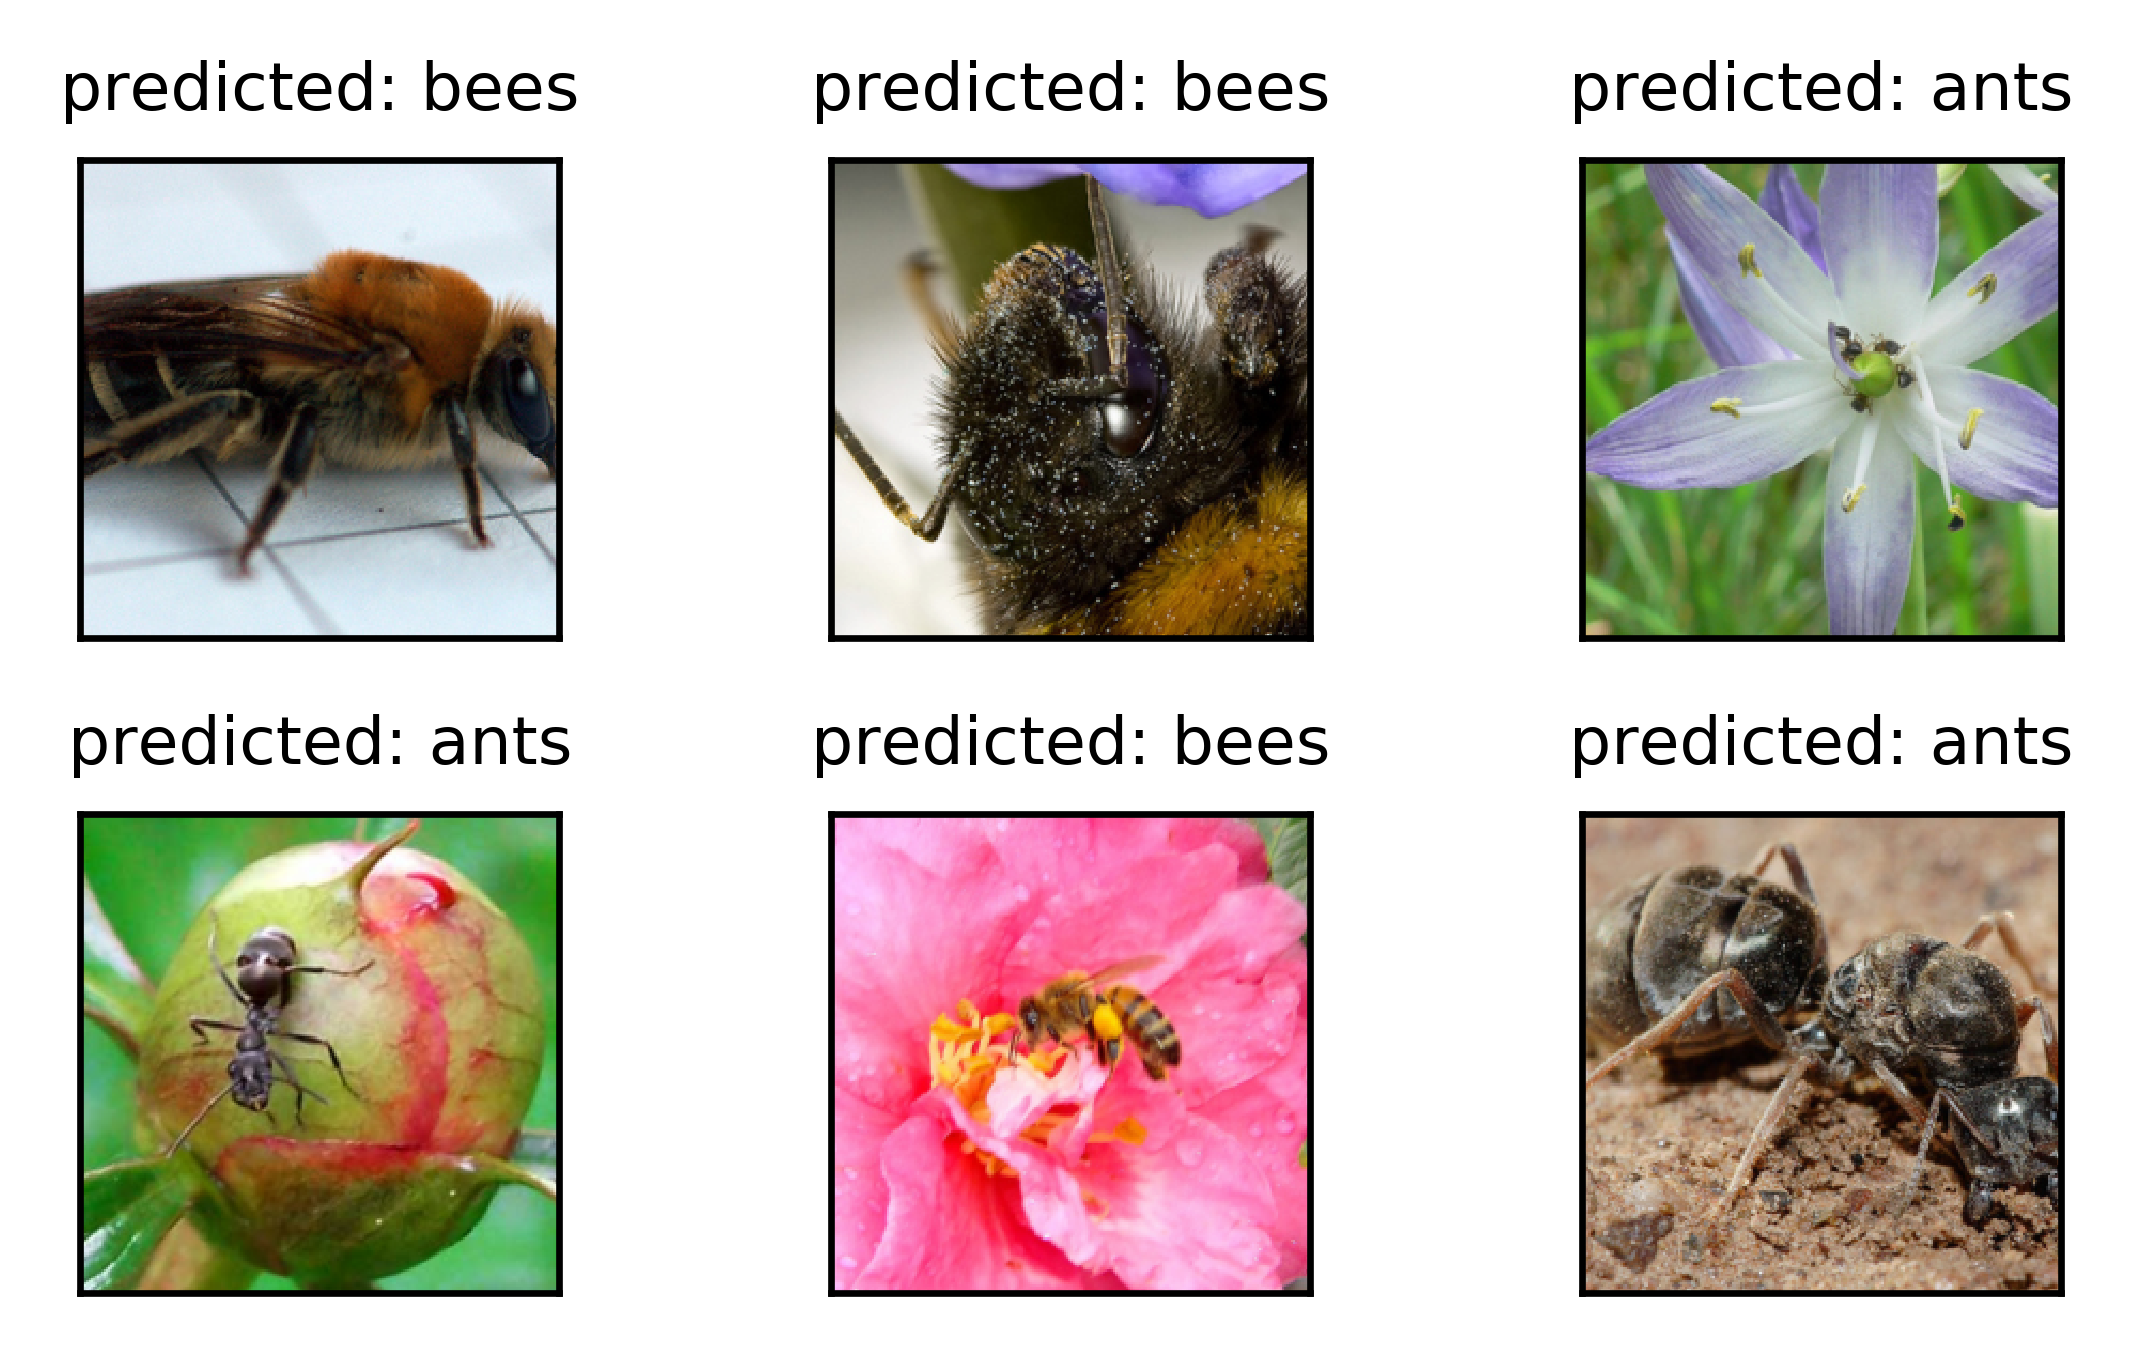

In [40]:
beatify(fig_width=4)
visualize_model(model_best)

**Questions**
1. How can you compare the two approaches above? 
2. What is the best score for each aproaches?

### 2. 2 Transfer learning 2:  VGG

VGG model is one of the most studied Deep learning models for transfer learning is VGG. The model can be split into two kinds of logical blocks

 **Convolution blocks**: The pre-trained VGG model is trained on Image net data set over 1000 categories. The convolutional block contains multiple convolution layers. The initial layers contain low level features like lines , curves . The last convolutional layers in this block contain more complex kind of features of images like hand, leg , eyes and many more.The convolution layers exhibit 2 important properties.
 - The number of parameters required is far less compared to fully connected layer. For example a Convolution layer with $3 * 3 * 64$ size filters need only 576 parameters.
 - Convolution layers are computationally expensive and take longer to compute the output.
 
**Fully Connected Block**: This block contains FC layers with dropouts. The number of parameters to learn in FC layers are huge but takes way less time to compute.

So, we generally end up taking pre convoluted features from Convolution block of VGG model as it is and training only the last few layers of the VGG model which are generally from FC block.

PyTorch's implementation of VGG is a module divided in two child
``Sequential`` modules: ``features`` (containing convolution and pooling
layers) and ``classifier`` (containing fully connected layers). We are
just interested by ``features``:

### 2.2.3 Load and define models for transfer learning using VGG 


Now, we have to import a pre-trained neural network.We
are going to use a pretrained VGG network with 19 layers (VGG19).

In [ ]:
model_vgg = models.vgg19(pretrained=True)

In [ ]:
print(model_vgg)

### Task: 

1. Use VGG as feature extractor to build CNN classify for the above problem, compare your results with the resnet18 models.
2. Fine tune VGG and build CNN classify for the above problem, compare your results with the resnet18 models.

** Task**:
- Use transfer learning to develop CNN model to classify dog and cat

## References

- [A Gentle Introduction to Transfer Learning for Deep Learning
](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)
- [Transfer Learning - Machine Learning's Next Frontier](http://ruder.io/transfer-learning/)
- [Transfer](http://cs231n.github.io/transfer-learning/)
- [Transfer learning using pytorch — Part 1](https://towardsdatascience.com/transfer-learning-using-pytorch-4c3475f4495)
- [Transfer learning using pytorch — Part 2](https://towardsdatascience.com/transfer-learning-using-pytorch-part-2-9c5b18e15551)